In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers, models
from sklearn.utils import class_weight

import cv2 

import warnings
warnings.filterwarnings('ignore')

2025-09-25 17:25:30.416758: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758821130.772626      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758821130.887843      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Bu bölümde **Chest X-Ray Pneumonia** veri setindeki görüntü sayıları incelenmiştir.  
Öncelikle eğitim (`train`) ve test (`test`) klasörlerindeki NORMAL ve PNEUMONIA sınıflarına ait dosya sayıları hesaplanmıştır.  

Eğitim setindeki Normal ve Pnömonili görüntü sayıları ayrı ayrı listelenir.  
Test seti için de aynı şekilde görüntü sayıları elde edilmiştir.  
Daha sonra eğitim setindeki sınıf dağılımı görselleştirilerek, veri dengesizliği olup olmadığı kontrol edilmiştir.
Çıktıyı incelediğimizde train veri setinde sınıf dengesizliği (class imbalance) vardır.  
Modelin adil ve doğru genelleme yapabilmesi için **data augmentation** veya **class weighting** gibi yöntemler gerekebilir.

Eğitim Seti - Normal Görüntü Sayısı: 1341
Eğitim Seti - Pnömonili Görüntü Sayısı: 3875
Test Seti - Normal Görüntü Sayısı: 234
Test Seti - Pnömonili Görüntü Sayısı: 390


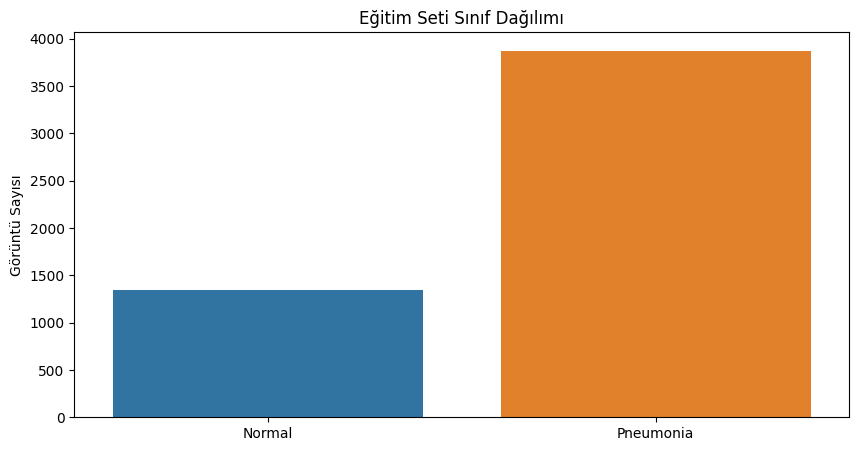

In [2]:
# Veri seti yollarını belirtin
base_dir = '../input/chest-xray-pneumonia/chest_xray'

train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

# Görüntü sayılarını hesaplama
train_normal = len(os.listdir(os.path.join(train_dir, 'NORMAL')))
train_pneumonia = len(os.listdir(os.path.join(train_dir, 'PNEUMONIA')))
test_normal = len(os.listdir(os.path.join(test_dir, 'NORMAL')))
test_pneumonia = len(os.listdir(os.path.join(test_dir, 'PNEUMONIA')))

print(f"Eğitim Seti - Normal Görüntü Sayısı: {train_normal}")
print(f"Eğitim Seti - Pnömonili Görüntü Sayısı: {train_pneumonia}")
print(f"Test Seti - Normal Görüntü Sayısı: {test_normal}")
print(f"Test Seti - Pnömonili Görüntü Sayısı: {test_pneumonia}")


# Görselleştirme
plt.figure(figsize=(10, 5))
sns.barplot(x=['Normal', 'Pneumonia'], y=[train_normal, train_pneumonia])
plt.title('Eğitim Seti Sınıf Dağılımı')
plt.ylabel('Görüntü Sayısı')
plt.show()

show_sample_images fonksiyonu, belirtilen bir dizin ve sınıf adı içinden rastgele seçilen iki görseli (num_samples=2 varsayılan değeriyle) gösterir. os modülü dosya yollarını oluşturur, numpy rastgele görsel adlarını seçer, cv2 (OpenCV) görselleri okur ve matplotlib.pyplot (plt) bu görselleri başlıkları (sınıf adı) ile birlikte temiz bir şekilde görüntüler.

Kodun devamındaki iki çağrı (show_sample_images(train_dir, 'NORMAL') ve show_sample_images(train_dir, 'PNEUMONIA')), eğitim veri setindeki (train_dir) NORMAL ve PNÖMONİ vakalarına ait örnek görselleri görsel olarak incelemeyi sağlar.

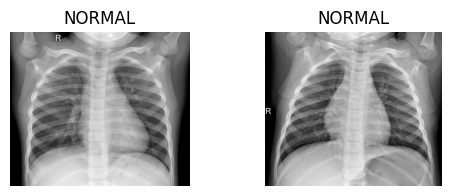

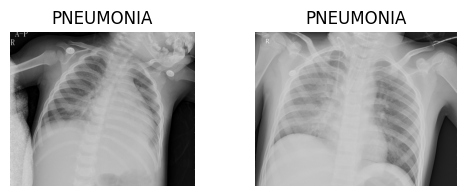

In [3]:
def show_sample_images(directory, class_name, num_samples=2):
    plt.figure(figsize=(6, 2))
    class_dir = os.path.join(directory, class_name)
    sample_images = np.random.choice(os.listdir(class_dir), num_samples)

    for i, img_name in enumerate(sample_images):
        img_path = os.path.join(class_dir, img_name)
        img = cv2.imread(img_path)
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(img)
        plt.title(f'{class_name}')
        plt.axis('off')
    plt.show()

show_sample_images(train_dir, 'NORMAL')
show_sample_images(train_dir, 'PNEUMONIA')

Bu kod bloğu, veri setini hazırlamak amacıyla Keras'ın ImageDataGenerator sınıfını kullanır. Bu işlem, modelin daha genelleştirilmiş öğrenmesi için veri çoğaltma (Data Augmentation) yapmayı ve veriyi toplu (batch) olarak yüklemeyi içerir.

Modelin aşırı öğrenmesini (overfitting) engellemek ve genelleme yeteneğini artırmak için train veri setine veri çoğaltma teknikleri uygulanır.

Test veri setine ise, verinin orijinal dağılımını korumak için sadece ölçekleme (rescale=1./255) uygulanır; veri çoğaltma işlemleri yapılmaz.

Ayrıca, burada validation verisi az olduğu için hazır datasette verilen dosya yerine, train içerisinden %10’luk bir kısım validation için ayrılmıştır.

In [4]:
# Görüntü boyutları ve batch büyüklüğünü belirleme
IMG_SIZE = (150, 150)
BATCH_SIZE = 32

# Eğitim verisi için veri çoğaltma (augmentation) ayarları ve doğrulama için ayırma
train_datagen = ImageDataGenerator(
    rescale=1./255,          # Pikselleri 0-1 arasına ölçekle
    rotation_range=20,       # Rastgele döndürme
    width_shift_range=0.1,   # Yatay kaydırma
    height_shift_range=0.1,  # Dikey kaydırma
    shear_range=0.1,         # Kırpma/Eğme
    zoom_range=0.1,          # Rastgele yakınlaştırma
    horizontal_flip=True,    # Yatay çevirme
    fill_mode= 'nearest',
    validation_split=0.1     # %10'unu validation için ayır
)

# Test verisi için sadece ölçekleme yapılır.
test_datagen = ImageDataGenerator(rescale=1./255)

# Veri üreteçlerini (generators) oluşturma
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training'       # Eğitim seti
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation'     # Doğrulama seti
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False           # Test verisinin sırasını karıştırmamak önemlidir
)

# Oluşturulan generator'ların çıktısını kontrol edelim
print("\nVeri üreteçleri başarıyla oluşturuldu!")

Found 4695 images belonging to 2 classes.
Found 521 images belonging to 2 classes.
Found 624 images belonging to 2 classes.

Veri üreteçleri başarıyla oluşturuldu!


Keras'ın Sequential API'si kullanılarak, ikili (binary) sınıflandırma görevi için tasarlanmış bir Evrişimsel Sinir Ağı (Convolutional Neural Network - CNN) modelini tanımlamaktadır. Model, görseldeki özellik haritalarını çıkarmak için birden fazla evrişim katmanını ve ardından sınıflandırma yapmak için yoğun katmanları kullanır.

Model, üç ana bölümden oluşur: Evrişim Blokları, Düzleştirme (Flatten) ve Yoğun (Dense) Sınıflandırma Katmanları.

Model, görseldeki özellikleri çıkarmak için art arda üç blok Evrişim (Conv2D) ve Maksimum Havuzlama (MaxPooling2D) katmanı kullanır; bu bloklar sırasıyla 32, 64 ve 128 filtre ile görseldeki karmaşık özellikleri öğrenir. Özellik çıkarma aşamasından sonra, çıkarılan 2 boyutlu özellik haritaları Düzleştirme (Flatten) katmanı ile tek boyutlu vektöre dönüştürülür. Sınıflandırma aşamasında, 128 nöronlu bir yoğun katman kullanılır ve aşırı öğrenmeyi (overfitting) önlemek için %50 oranında Dropout uygulanır. Modelin son katmanı, çıktıyı 0 ile 1 arasında bir olasılığa çeviren sigmoid aktivasyonuna sahip tek bir nöron içerir, bu da ikili sınıflandırma probleminin nihai sonucunu verir.


In [5]:

model = models.Sequential([

    # 1. Convolution + Pooling
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)),
    layers.MaxPooling2D((2,2)),

    # 2. Convolution + Pooling
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    # 3. Convolution + Pooling
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    # Flatten (2D feature map → 1D vector)
    layers.Flatten(),

    # Fully Connected Layer
    layers.Dense(128, activation='relu'),

    # Dropout (overfitting azaltmak için)
    layers.Dropout(0.5),

    layers.Dense(1, activation='sigmoid')  # binary classification
])

I0000 00:00:1758821152.272222      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1758821152.273131      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


model.summary() komutu, tanımlanan Evrişimsel Sinir Ağı'nın (CNN) yapısını özetleyen kritik bir araçtır. Bu çıktı; modeldeki her katmanın adını, tipini, çıktı şeklini (Output Shape) ve o katmanda kullanılan öğrenilebilir parametre sayısını (Param #) gösterir. Özellikle çıktı şekillerini kontrol etmek, verinin her katmanda doğru şekilde dönüştürüldüğünden emin olmak için önemlidir. Özetteki toplam parametre sayısı ise (Toplam parametreler, Eğitilebilir parametreler, Eğitilemez parametreler), modelin karmaşıklığı ve bellek gereksinimleri hakkında bilgi verir. 

In [6]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,828,481 (18.42 MB)

 Trainable params: 4,828,481 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

model.compile() fonksiyonu, Adam optimizasyon algoritmasını kullanarak modelin ağırlıklarını güncellemesini, binary_crossentropy kaybını en aza indirmeye çalışmasını ve performansını doğruluk (accuracy) metriği üzerinden raporlamasını söyler. Kısacası, bu kod modelin "nasıl öğreneceği" ile ilgili temel kuralları belirler.

In [7]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',   # çünkü 2 sınıf var
    metrics=['accuracy']
)

Eğitim veri setinde sınıflar dengeli olmadığından dolayı (Normal=1341, Pnömoni=3875), model çoğunluk sınıfına odaklanabilir ve azınlık sınıfını doğru öğrenemeyebilir.  
Bunu çözmek için **class weights** kullanılır.

In [8]:
# Eğitim etiketlerini say
labels = train_generator.classes  # 0 = Normal, 1 = Pnömoni

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)
class_weights = dict(enumerate(class_weights))
print(class_weights)

{0: 1.9449047224523612, 1: 0.6730217889908257}


Early stopping, modelinizin en iyi performansı gösterdiği noktada eğitimi otomatik olarak durdurur ve en iyi ağırlıkları kaydeder. Böylece:

Model, test verisi üzerinde genelleme yapma yeteneğini kaybetmeden eğitimi sonlandırır.

Gereksiz yere devam eden eğitim adımları (epoch'lar) atlandığı için zamandan ve işlem gücünden tasarruf edersiniz.

En yüksek doğrulama doğruluğuna sahip modeliniz otomatik olarak kaydedilir.

In [9]:

early_stopping = EarlyStopping(
    monitor='val_loss', # Hangi metriği izleyeceğimizi belirtir
    patience=5,         # Bu metrik 5 epoch boyunca iyileşmezse durdur
    restore_best_weights=True # En iyi performansı veren epoch'un ağırlıklarını geri yükle
)

Bu komut, tanımlanan Evrişimsel Sinir Ağı (CNN) modelinin eğitim sürecini başlatır ve sonuçlarını history değişkenine kaydeder. 
Eğitim, train_generator tarafından sağlanan eğitim verisi üzerinde 50 epochs boyunca devam ederken, her dönemin sonunda validation_generator kullanılarak modelin doğrulama (validation) performansı ölçülür.
Eğitim sürecindeki önemli ayarlamalar şunlardır: class_weights parametresi, veri setindeki sınıf dengesizliğini gidermek için sınıflara ağırlık atar; early_stopping ise belirlenen bir performans kriterinde (örneğin doğrulama kaybı) iyileşme durduğunda, aşırı öğrenmeyi (overfitting) önlemek amacıyla eğitimi erken sonlandıran bir geri çağırma (callback) mekanizmasıdır.

In [10]:
history = model.fit(
    train_generator,
    epochs=50,         
    validation_data=validation_generator,
    class_weight=class_weights,
    callbacks= early_stopping
)

Epoch 1/50


I0000 00:00:1758821158.280458     123 service.cc:148] XLA service 0x7c2cc80054a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758821158.282252     123 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1758821158.282278     123 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1758821158.758932     123 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/147 ━━━━━━━━━━━━━━━━━━━━ 19:37 8s/step - accuracy: 0.8125 - loss: 0.6360

I0000 00:00:1758821163.168563     123 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


147/147 ━━━━━━━━━━━━━━━━━━━━ 104s 660ms/step - accuracy: 0.6088 - loss: 0.6475 - val_accuracy: 0.7908 - val_loss: 0.4474
Epoch 2/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 69s 469ms/step - accuracy: 0.8549 - loss: 0.3450 - val_accuracy: 0.8388 - val_loss: 0.3613
Epoch 3/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 67s 454ms/step - accuracy: 0.8872 - loss: 0.2742 - val_accuracy: 0.8964 - val_loss: 0.2331
Epoch 4/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 64s 435ms/step - accuracy: 0.8946 - loss: 0.2772 - val_accuracy: 0.9002 - val_loss: 0.2682
Epoch 5/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 66s 450ms/step - accuracy: 0.9103 - loss: 0.2250 - val_accuracy: 0.9290 - val_loss: 0.1812
Epoch 6/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 67s 457ms/step - accuracy: 0.9099 - loss: 0.2078 - val_accuracy: 0.8944 - val_loss: 0.2802
Epoch 7/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 67s 458ms/step - accuracy: 0.9111 - loss: 0.2137 - val_accuracy: 0.8848 - val_loss: 0.2701
Epoch 8/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 69s 466ms/step - accuracy: 0.9181 - loss: 0.2046 - va

Eğitim tamamlandıktan sonra modelin **genel performansını** görmek için test seti kullanılır.
Modelin test verisi üzerinde loss (kayıp) ve accuracy (doğruluk) değerlerini hesaplar.
Loss: Modelin tahminlerinin gerçek değerlerden ne kadar saptığını gösterir.
Accuracy: Modelin test verisindeki doğruluk oranını gösterir.

In [11]:
test_loss, test_acc = model.evaluate(test_generator)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 355ms/step - accuracy: 0.8390 - loss: 0.3701
Test Loss: 0.28488707542419434
Test Accuracy: 0.8717948794364929


Modelin eğitimden dönen history nesnesini kullanarak eğitim sürecinin performansını görselleştirmek için tasarlanmıştır. 
İlk olarak, eğitim ve doğrulama setlerine ait doğruluk (accuracy, val_accuracy) ve kayıp (loss, val_loss) değerlerini çeker. Ardından, matplotlib.pyplot (plt) kütüphanesini kullanarak iki alt grafik oluşturur: Doğruluk Grafiği, modelin eğitim ve doğrulama doğruluğunun dönemler (epochs) boyunca nasıl değiştiğini gösterir; Kayıp (Loss) Grafiği ise aynı süreçteki eğitim ve doğrulama kaybı değerlerinin seyrini izler.
Bu görseller, modelin aşırı öğrenme (overfitting) veya eksik öğrenme (underfitting) gibi sorunlar yaşayıp yaşamadığını ve eğitim sürecinin genel başarısını analiz etmek için öneme sahiptir.

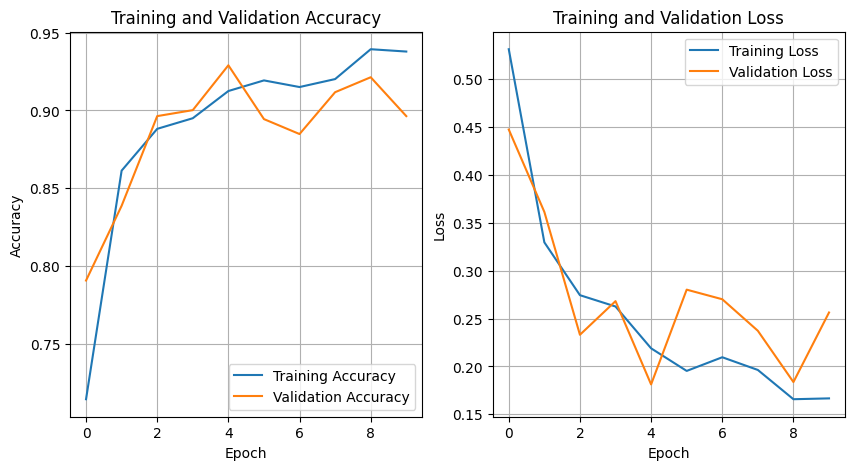

In [15]:

# History objesinden değerleri al
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

# Dogruluk grafigi
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)

# Kayıp (Loss) grafiği
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

Bu kod bloğu, eğitilmiş Evrişimsel Sinir Ağı (CNN) modelinin test veri seti üzerindeki nihai performansını değerlendirmek için kullanılır.
İlk olarak, test_generator sıfırlanır ve modelin predict metodu kullanılarak tüm test verisi üzerindeki olasılık tahminleri alınır. 
Bu sürekli tahminler, 0.5 eşiği kullanılarak ikili sınıflara (0 veya 1) dönüştürülür ve gerçek etiketlerle karşılaştırılır. 
Elde edilen gerçek ve tahmin edilen değerler kullanılarak bir Karmaşıklık Matrisi (Confusion Matrix) oluşturulur ve seaborn.heatmap ile görselleştirilir; bu matris, modelin her bir sınıfı ne kadar doğru veya yanlış sınıflandırdığını sayısal olarak gösterir. Son olarak, modelin kesinlik (precision), hatırlama (recall) ve F1-skoru gibi ayrıntılı performans metriklerini içeren Sınıflandırma Raporu (classification_report) yazdırılır.
Bu adımlar, modelin gerçek dünya verileri üzerindeki etkinliğini kapsamlı bir şekilde analiz etmeyi sağlar.

20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 232ms/step


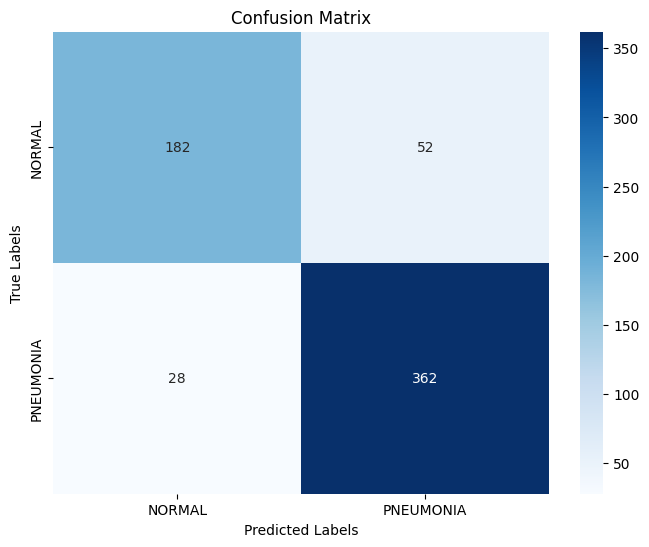


Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.87      0.78      0.82       234
   PNEUMONIA       0.87      0.93      0.90       390

    accuracy                           0.87       624
   macro avg       0.87      0.85      0.86       624
weighted avg       0.87      0.87      0.87       624



In [16]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

test_generator.reset()
predictions = model.predict(test_generator, steps=len(test_generator))

# Tahminleri ikili sınıflara dönüştür (0.5 eşiğiyle)
y_pred_classes = (predictions > 0.5).astype(int).flatten()
y_true_classes = test_generator.classes

# Confusion Matrix oluştur ve görselleştir
cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['NORMAL', 'PNEUMONIA'],
            yticklabels=['NORMAL', 'PNEUMONIA'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Classification Report oluştur
print("\nClassification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=['NORMAL', 'PNEUMONIA']))

Görüntünün hangi bölgelerine odaklandığını görselleştiren güçlü bir teknik olan Grad-CAM (Gradient-weighted Class Activation Mapping) algoritmasını uygular. 

İlk olarak test setinden bir görüntü almayı, ardından orijinal modelin girişini ve son evrişim katmanı ile çıktı katmanını birleştiren özel bir grad_model oluşturmayı içerir. Bu model kullanılarak, tahmin edilen sınıfa ait gradyanlar (gradients) hesaplanır ve bunlar son evrişim katmanının çıktılarıyla çarpılarak bir ısı haritası (heatmap) elde edilir. Son olarak, bu ısı haritası cv2 (OpenCV) kullanılarak orijinal görüntü boyutuna yeniden boyutlandırılır, renklendirilir ve şeffaflıkla orijinal görselin üzerine bindirilerek modelin karar verme noktaları görselleştirilir. 

Çıktı, orijinal görüntü, heatmap ve Grad-CAM sonucu olmak üzere üç görselin yanı sıra, modelin gerçek etiketi, tahmini ve bu tahmine olan güvenini gösteren metinsel bir özet sunar. Bu analiz, modelin sadece doğru tahmin yapıp yapmadığını değil, aynı zamanda mantıklı gerekçelerle mi tahminde bulunduğunu anlamak için kritik öneme sahiptir.

Model, ilk kez girdi ile çalıştırılıyor (building the model)...
Model başarıyla kuruldu ve katmanları hazır.
Grad-CAM modeli, functional API yapısı kullanılarak başarıyla oluşturuldu.


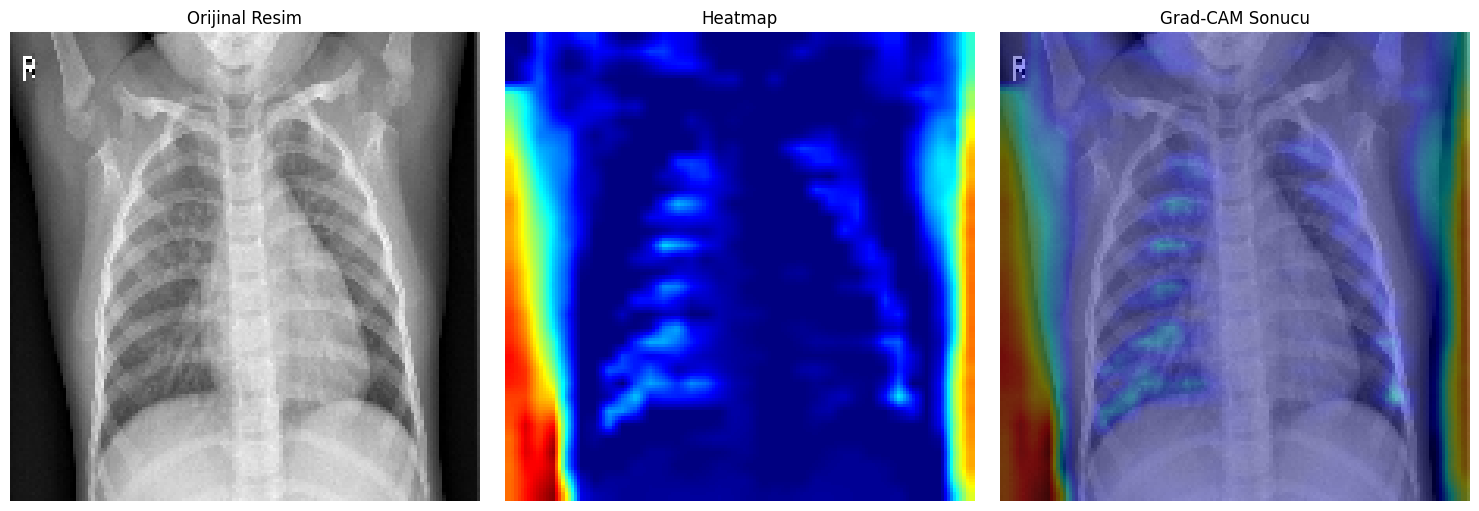


----- Tahmin ve Doğruluk Kontrolü -----
Gerçek Etiket (Sınıf İndeksi): 0
Model Tahmini (Sınıf İndeksi): 0
Model Güveni (Olasılık): 0.2127
✅ TAHMİN DOĞRU


In [19]:
# Test setinden bir batch al
img_array, label = next(test_generator)

# Modeli tam olarak kurmak ve çalıştırmak için:
print("Model, ilk kez girdi ile çalıştırılıyor (building the model)...")
_ = model(img_array)
print("Model başarıyla kuruldu ve katmanları hazır.")

# 1. Orijinal modelin giriş tensörünü alın
input_tensor = model.layers[0].input
last_conv_layer_name = "conv2d_2"
LAST_DENSE_LAYER_NAME = "dense_1" 
# 2. Orijinal modelin son evrişim katmanının çıktısını alın
last_conv_output = model.get_layer(last_conv_layer_name).output

# 3. Modelin nihai çıktısını alın (preds)
final_output = model.get_layer(LAST_DENSE_LAYER_NAME).output

# 4. Grad-CAM Modelini oluşturun (Artık Keras, tensörleri doğrudan tanıyacaktır)
grad_model = tf.keras.models.Model(
    inputs=input_tensor,
    outputs=[last_conv_output, final_output]
)

print("Grad-CAM modeli, functional API yapısı kullanılarak başarıyla oluşturuldu.")

# 3. Gradyanları ve Çıktıları Hesaplayın
with tf.GradientTape() as tape:
    last_conv_layer_output, preds = grad_model(img_array)
    # Tahmin edilen sınıfın indeksini alın
    pred_index = tf.argmax(preds[0])
    # Hedef sınıfın skorunu alın
    class_channel = preds[:, pred_index]

# 4. Gradyanları Hesaplayın
grads = tape.gradient(class_channel, last_conv_layer_output)
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2)) # Global Average Pooling

# 5. Heatmap'i Oluşturun
last_conv_layer_output = last_conv_layer_output[0]
heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
heatmap = tf.squeeze(heatmap)

# 6. ReLU ve Normalizasyon
heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)

# 7. Görselleştirme (OpenCV ve Matplotlib ile)
# Orijinal görüntüyü alın ve normalize edin (eğer gerekiyorsa)
original_img = img_array[0]
if np.max(original_img) <= 1.0:
    original_img = original_img * 255.0
original_img = np.uint8(original_img)

# a) Heatmap'i orijinal resim boyutuna yeniden boyutlandır
heatmap_resized = cv2.resize(heatmap.numpy(), (original_img.shape[1], original_img.shape[0]))

# b) Heatmap'i renk paletine (örn. JET) uygula
heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)

# c) Renkli heatmap'i BGR'den RGB'ye çevir
heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB)

# d) Orijinal görüntü üzerine şeffaflıkla bindir
alpha = 0.4
superimposed_img = cv2.addWeighted(original_img, 1 - alpha, heatmap_colored, alpha, 0)

# Sonucu Matplotlib ile göster
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(original_img)
axes[0].set_title("Orijinal Resim")
axes[0].axis('off')

axes[1].imshow(heatmap_colored)
axes[1].set_title("Heatmap")
axes[1].axis('off')

axes[2].imshow(superimposed_img)
axes[2].set_title("Grad-CAM Sonucu")
axes[2].axis('off')

plt.tight_layout()
plt.show()

# Tahmin sonucunu yazdır
true_label_index = np.argmax(label[0])
predicted_index = tf.argmax(preds[0]).numpy()
confidence = preds[0, predicted_index].numpy()

print("\n----- Tahmin ve Doğruluk Kontrolü -----")
print(f"Gerçek Etiket (Sınıf İndeksi): {true_label_index}")
print(f"Model Tahmini (Sınıf İndeksi): {predicted_index}")
print(f"Model Güveni (Olasılık): {confidence:.4f}")

if predicted_index == true_label_index:
    print("✅ TAHMİN DOĞRU")
else:
    print(f"❌ TAHMİN YANLIŞ: Model, sınıf {true_label_index} yerine sınıf {predicted_index}'i tahmin etti.")